In [1]:
# Imports and device setting

import os
import torch
import pickle 
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms as T 
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import requests
import spacy


from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Imports and device setting
# Building Image Captioning in PyTorch

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexibility of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network with an appropriate attention mechanism to appropriately weight the feature maps.

1. Read about and download the Flickr8k dataset from <a href="https://www.kaggle.com/adityajn105/flickr8k/activity">here</a> .

1. Create a preprocessing pipeline by creating a custom Pytorch  <a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">dataset</a>. Note that the data contains both images and caption annotation, so you will need to encode the text and map each character to an integer\One-hot vector (Remember to add start of sentence and end of sentence tokens) and apply torchvision.transforms to normalize the images as was done in previous homeworks.

1. Define the feature extractor. This model should take in an image and perform feature extraction on it. You can use a pretrained network such as ResNet (remember to normalize the input image) for this task or create your own Network.

1. Implement an attention mechanism as was described in class that will weight the feature maps for the RNN model.

1. Feed the feature maps that were weighted by the attention mechanism into the LSTM\GRU\RNN decoder that will generate the actual captions.

1. Train your model. Training a proper model might take a while, so you are encouraged to use [Colab](https://colab.research.google.com/).

6. Create function that takes the learned network and predicts a single word. This function should take a hidden state and an input character, and output the next hidden state and the predicted word.
7. Finally, create a sampling function that takes the network, the maximum length of text and produces a caption.


In [ ]:
# Getting data from Kaggle, as suggested in piazza by daniel

!pip install kaggle
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip

In [3]:
data_path =  "/content"
captions_path = data_path + '/captions.txt'
df = pd.read_csv(captions_path)
spc = spacy.load("en")

In [4]:
# A word based vocabulary class for numerically representing texts

class Vocabulary:
    def __init__(self,freq_threshold):
        # Int to string dict
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

        # String to int dict
        self.stoi = {v:k for k,v in self.itos.items()}

        # How ofter a word should appear in the text in order to be added to the vocabulary
        self.freq_threshold = freq_threshold
        
    def __len__(self):
      return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spc.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        word_frequencies = Counter()  # Count the occurrences of each word
        idx = 4 # Chars 0 through 3 are reserved
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                word_frequencies[word] += 1
                
                # If a word appeared enough times: add it to the vocabulary
                if word_frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        # Returns a list of integers representing the words in the text
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [5]:
# A dataset class for the flickr8k dataset

class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        # The root working directory
        self.root = root_dir

        # Dataframe from csv captions file
        self.df = pd.read_csv(captions_path)

        # Transformation function to apply to images (optional)
        self.transform = transform
        
        # Images and captions colum from the dataframe
        self.images = self.df["image"]
        self.captions = self.df["caption"]
        
        # Create and build vocabulary
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,i):
        # Returns a tuple of:
        # 1. transformed image in index i
        # 2. numericalized caption of the image
        caption = self.captions[i]
        img_name = self.images[i]
        img_location = os.path.join(self.root,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        caption_vec = []
        caption_vec += ([self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]])
        
        return img, torch.tensor(caption_vec)

In [6]:
def show_image(img, title=None):
    # Utility function for displaying tensors as images

    # Unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated


In [7]:
# A class for stacking captions for a batch of images
# by padding them (the captions) to the same size.
class CaptionConcat:
    def __init__(self,pad_value,batch_first=False):
        self.pad_value = pad_value
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        # Concat the targets along a new axis
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_value)
        return imgs,targets



In [8]:
# Some dataset & dataloader settings prior to the models

# Defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# Create Dataset
dataset =  FlickrDataset(
    root_dir = data_path+"/Images",
    captions_file = data_path+"/captions.txt",
    transform=transforms
)

# Set dataloader constants
BATCH_SIZE = 256
NUM_WORKER = 4

# Set token to represent the padding value
pad_value = dataset.vocab.stoi["<PAD>"]

# Create the dataloader
data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CaptionConcat(pad_value=pad_value,batch_first=True)
)

# Vocabulary size
vocab_size = len(dataset.vocab)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Load resnet and freeze its parameters so its not ruined during training
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # Remove the last fully connected layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
         
    def forward(self, images):
        # Plug images into resnet to extract their mapping before calculating attention 
        output = self.resnet(images)                                  
        output = output.permute(0, 2, 3, 1)                           
        output = output.view(output.size(0), -1, output.size(-1)) 
        return output

In [10]:
# An attention module based on https://machinelearningmastery.com/the-bahdanau-attention-mechanism/

class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W_q = nn.Linear(decoder_dim,attention_dim)
        self.W_k = nn.Linear(encoder_dim,attention_dim)
        self.A = nn.Linear(attention_dim,1)
          
        
    def forward(self, input, hidden_state):
        # Run input and queries through fc layers
        k = self.W_k(input) 
        q = self.W_q(hidden_state)
        
        # Activation function
        combined_states = torch.tanh(k + q.unsqueeze(1))
        
        # Another fc layer
        alignment = self.A(combined_states)
        alignment = alignment.squeeze(2)
        
        # Run softmax on alignment over axis 1
        alpha = F.softmax(alignment,dim=1)
        
        # Mult. then Add
        weighted_inputs = input * alpha.unsqueeze(2)
        y = weighted_inputs.sum(dim=1)
        
        return y
        

In [11]:
class RNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_p=0.3):
        super().__init__()
        
        # Save the model paramaters
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        # Generate embedding & attention moudles
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        # Generate fc layers for hiddes states and cells as well as an LSTM cell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        #self.f_b = nn.Linear(decoder_dim, encoder_dim)
        
        # Final fc layer for choosing next word
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        
        # Dropout module
        self.dropout = nn.Dropout(drop_p)
        
    
    def forward(self, input, captions):
        
        # Vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM states
        hidden_state, cell = self.init_hidden_state(input)
        
        # Get the sequence length to iterate over (exclude last word as it has no target value)
        caption_len = len(captions[0])-1
        batch_size = captions.size(0)
        num_inputs = input.size(1)
        
        # Generate empty tensors to hold the predictions
        preds = torch.zeros(batch_size, caption_len, self.vocab_size).to(device)
                
        # Iterate over words in the caption
        for w in range(caption_len):
            # Calculate attention and insert context into lstm then fc to generate predicted output
            context = self.attention(input, hidden_state)
            lstm_input = torch.cat((embeds[:, w], context), dim=1)
            hidden_state, cell = self.lstm(lstm_input, (hidden_state, cell))
                    
            output = self.fcn(self.dropout(hidden_state))
            
            preds[:,w] = output
        
        
        return preds
    
    def generate(self,input,max_len=20,vocab=None):
        # Recieve input from CNN to generate captions up to max_len words long

        batch_size = input.size(0)
        hidden_state, cell = self.init_hidden_state(input)
        
        # Set start of caption as 'Start Of Sequence" token
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        captions = []
        
        # Generate words until 'End Of Sequence' is generated or 20 words are generated 
        for i in range(max_len):
            # Calculate attention and insert context into lstm then fc to generate predicted output
            context = self.attention(input, hidden_state)
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            hidden_state, cell = self.lstm(lstm_input, (hidden_state, cell))
            output = self.fcn(self.dropout(hidden_state))
            output = output.view(batch_size,-1)
            
            # Get most likely word
            predicted_word_idx = output.argmax(dim=1)
            
            # Save generated word
            captions.append(predicted_word_idx.item())
            
            # End if 'End Of Sequence' is generated
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        hidden_state = self.init_h(mean_encoder_out)
        cell = self.init_c(mean_encoder_out)
        return hidden_state, cell

In [12]:
# The complete module used for training

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = CNN()
        self.decoder = RNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [13]:
# Define hyperparamaters
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512

# Create enc-dec model
model = EncoderDecoder(
    embed_size = embed_size,
    vocab_size = len(dataset.vocab),
    attention_dim = attention_dim,
    encoder_dim = encoder_dim,
    decoder_dim = decoder_dim
).to(device)

# Set criterion/optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), 5e-4)


Epoch: 1 loss: 4.18717


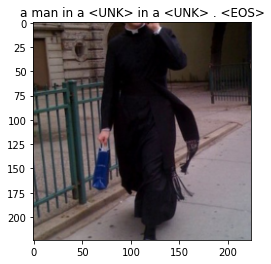

Epoch: 2 loss: 3.38402


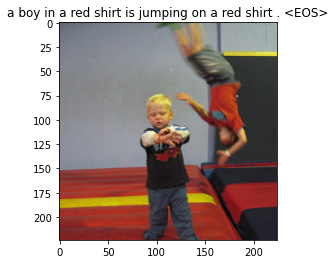

Epoch: 3 loss: 3.11945


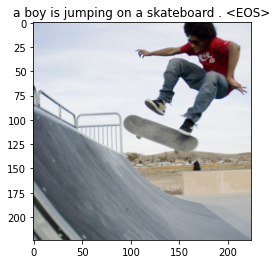

Epoch: 4 loss: 2.86824


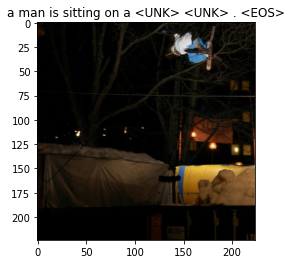

Epoch: 5 loss: 2.81489


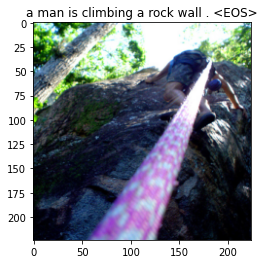

Epoch: 6 loss: 2.67262


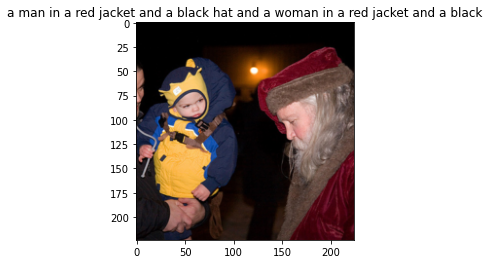

Epoch: 7 loss: 2.55693


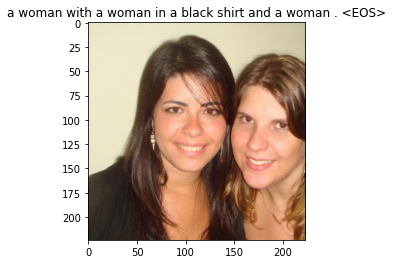

Epoch: 8 loss: 2.55156


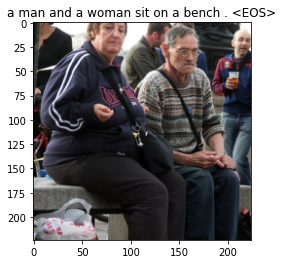

Epoch: 9 loss: 2.51802


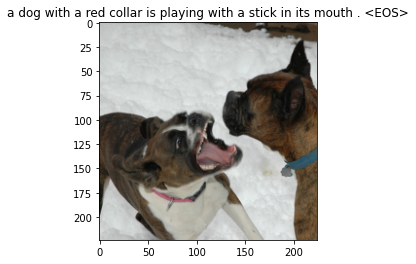

Epoch: 10 loss: 2.39538


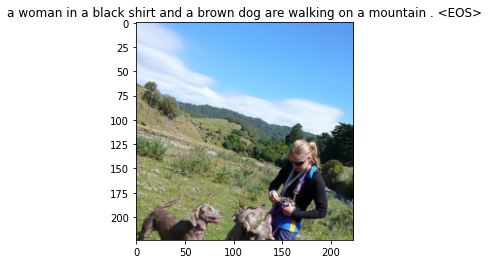

Epoch: 11 loss: 2.35133


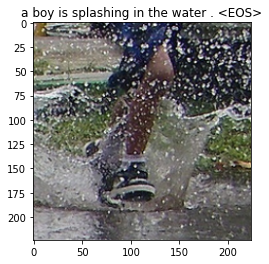

Epoch: 12 loss: 2.48462


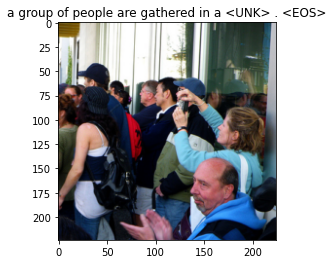

Epoch: 13 loss: 2.28004


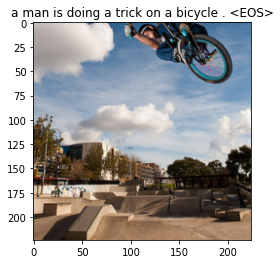

Epoch: 14 loss: 2.28644


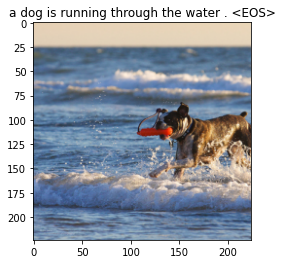

Epoch: 15 loss: 2.25877


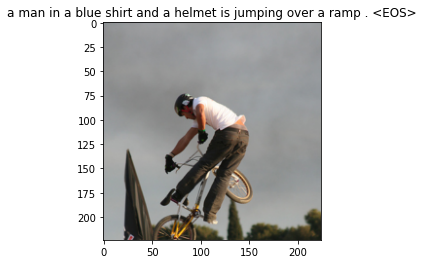

Epoch: 16 loss: 2.23850


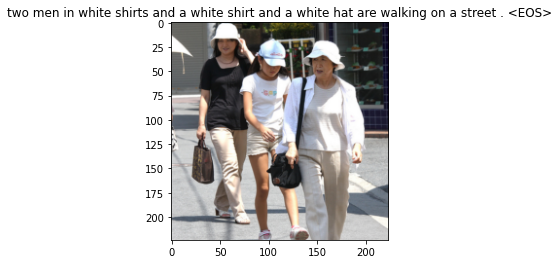

Epoch: 17 loss: 2.19057


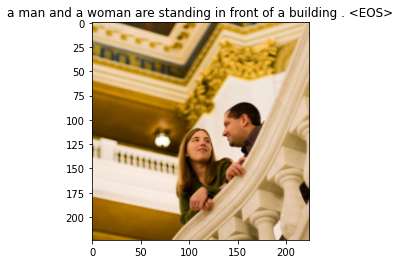

Epoch: 18 loss: 2.18309


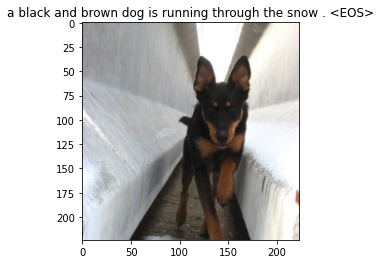

Epoch: 19 loss: 2.18468


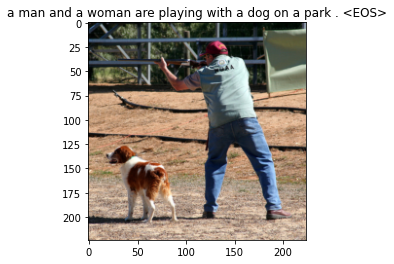

Epoch: 20 loss: 2.16306


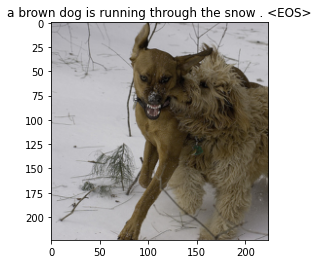

Epoch: 21 loss: 2.05439


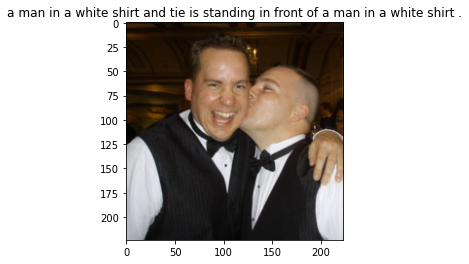

Epoch: 22 loss: 2.06395


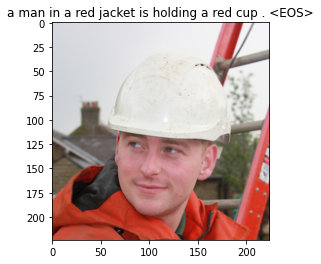

Epoch: 23 loss: 2.03499


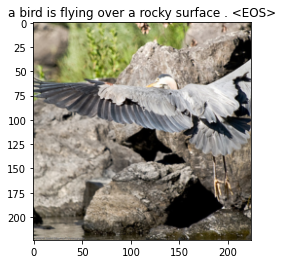

Epoch: 24 loss: 2.12088


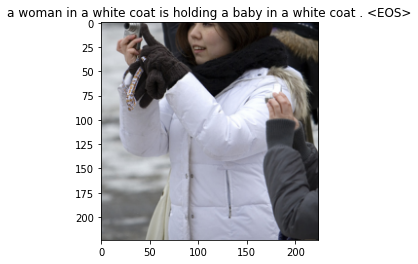

Epoch: 25 loss: 2.00950


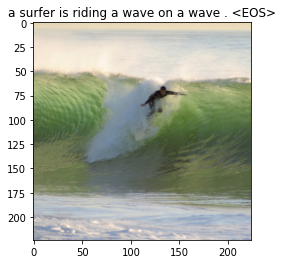

Epoch: 26 loss: 1.93638


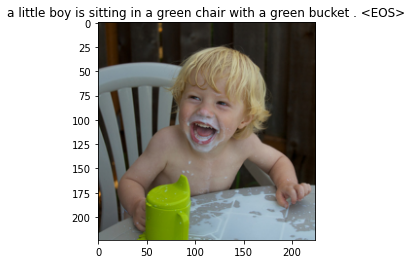

Epoch: 27 loss: 2.02123


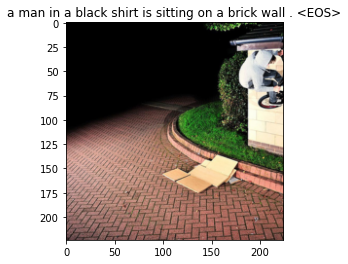

Epoch: 28 loss: 1.88487


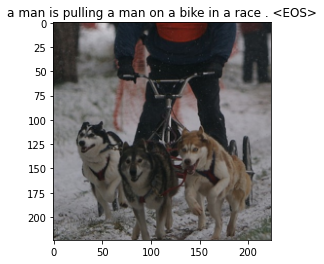

Epoch: 29 loss: 1.89015


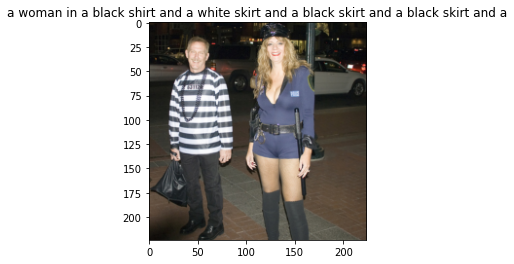

Epoch: 30 loss: 1.89881


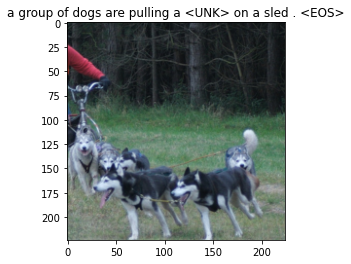

Epoch: 31 loss: 1.87893


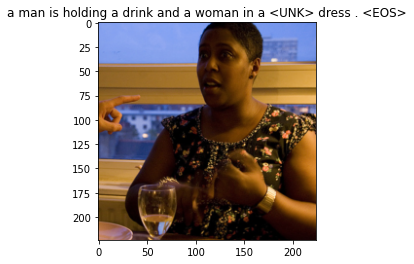

Epoch: 32 loss: 1.82868


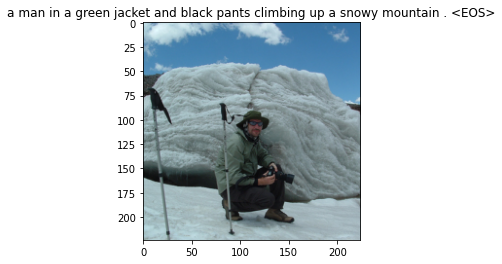

Epoch: 33 loss: 1.80956


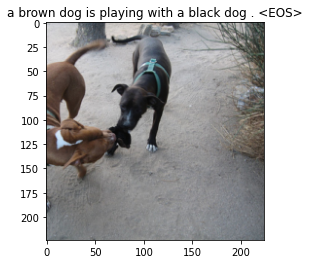

Epoch: 34 loss: 1.82467


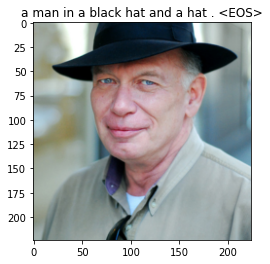

Epoch: 35 loss: 1.83558


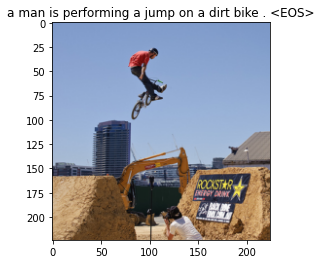

In [14]:
# Training sequence

for epoch in range(1, 36):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Forward pass
        outputs = model(image, captions)

        # Calculate batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        if (idx+1)%100 == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            #generate caption for example
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()